In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pywt
from pywt import wavedec

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams.update({'font.size': 12})

In [2]:
df = pd.read_csv('raw_data.csv', index_col = ['moment'], parse_dates = ['moment'])

,SM_Exgauster\[0:0],SM_Exgauster\[0:1],SM_Exgauster\[0:2],SM_Exgauster\[0:3],SM_Exgauster\[0:4],SM_Exgauster\[0:5],SM_Exgauster\[0:6],SM_Exgauster\[0:7],SM_Exgauster\[0:8],SM_Exgauster\[0:9],...,SM_Exgauster\[6:2],SM_Exgauster\[6.0],SM_Exgauster\[7:0],SM_Exgauster\[7:1],SM_Exgauster\[7:2],SM_Exgauster\[7.0],SM_Exgauster\[8:0],SM_Exgauster\[8:1],SM_Exgauster\[8:2],SM_Exgauster\[8.0]
moment,,,,,,,,,,,,,,,,,,,,,
2023-01-25 06:32:25.125007,1.284722,1.689815,0.964621,1.614583,2.089120,1.440972,2.001208,1.539352,1.494385,1.765046,...,2.600589,1.0,625.000000,138.372635,3.098138,1.0,0.723379,15.567306,-5.605194e-45,0.0
2023-01-25 06:33:25.125007,1.267361,1.689815,0.962173,1.626158,2.065972,1.417824,1.997886,1.556713,1.482208,1.741898,...,2.594604,1.0,617.404541,138.209290,3.100688,1.0,0.723379,15.139420,-5.605194e-45,0.0
2023-01-25 06:34:25.125007,1.296296,1.701389,0.971429,1.620370,2.083333,1.429398,1.990758,1.527778,1.489869,1.712963,...,2.591550,1.0,618.438721,138.295776,3.107095,1.0,0.723379,15.138195,-5.605194e-45,0.0
2023-01-25 06:35:25.125007,1.255787,1.689815,0.971007,1.614583,2.077546,1.429398,2.019292,1.516204,1.489961,1.712963,...,2.686367,1.0,622.107178,138.080093,3.112228,1.0,0.723379,15.138195,-5.605194e-45,0.0
2023-01-25 06:36:25.125007,1.302083,1.701389,0.966538,1.620370,2.112268,1.452546,1.981981,1.562500,1.494923,1.770833,...,2.692058,1.0,617.766602,138.354065,3.106137,1.0,0.723379,15.138195,-5.605194e-45,0.0


In [3]:
vibr_ax = 'SM_Exgauster\[0:8]'
vibr_ax8 = 'SM_Exgauster\[0:11]'

<AxesSubplot:xlabel='moment'>

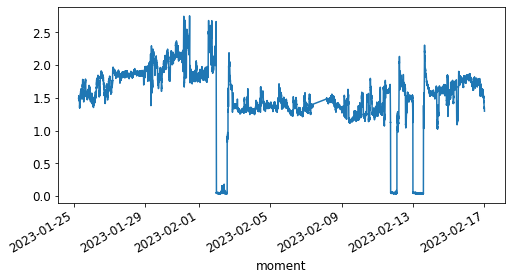

In [4]:
df[vibr_ax].plot()

# Применим разложение хаара к вибрации

Преобразования Фурье будет работать очень хорошо, когда частотный спектр стационарный. 
Чем нестационарнее сигнал, тем хуже будут результаты. Это проблема, так как большинство сигналов, которые мы видим в реальной жизни, нестационарны по своей природе.
У нас сигнал не стационарен! Поэтому мы и должны смотреть что-то сложнее Фурье

In [5]:
cA, cD = wavedec(df[vibr_ax].values, 'haar', mode='zero', level=1)

На выходе 2 вектора: 

Коэффициенты аппроксимации (cA) представляют выход фильтра нижних частот (фильтра усреднения) DWT. Коэффициенты детализации (cD) представляют выход фильтра высоких частот (разностного фильтра) DWT.

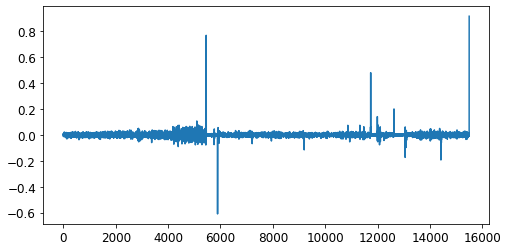

In [6]:
plt.plot(cD)

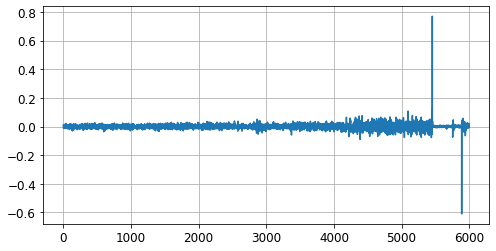

In [7]:
plt.grid()
plt.plot(cD[0:6000])

## Попробуем построить модель

In [8]:
from sklearn.linear_model import LinearRegression, Ridge

In [9]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# mean_r = moving_average(np.abs(cD), 20)

# x_train = mean_r[0:5000]

In [10]:
# проходим скользящим окном и выбираем максимальные значения cD

max_r = np.lib.stride_tricks.sliding_window_view(np.abs(cD), 20).max(axis=1)

# для построения выбираем 0:5000 значений cD
# на 5000:6000 будем как бы "тестировать"
x_train = max_r[0:5000]

In [11]:
x_train = x_train[~np.isnan(x_train)]

In [15]:
time = np.arange(0, len(x_train), 1)
model = Ridge() # линейное уравнение, но с коэффициентом регуляризации
model.fit(time.reshape(-1, 1), x_train)

Ridge()

In [13]:
x_for_plot = np.arange(0, 6000)
predict = model.predict(x_for_plot.reshape(-1, 1))

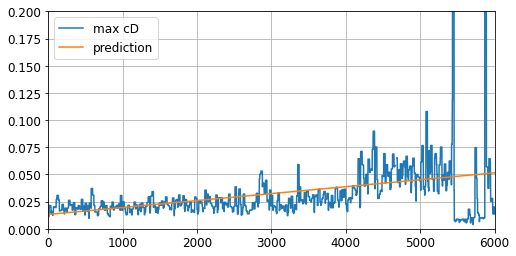

In [14]:
plt.grid()
plt.plot(max_r, label='max cD')
plt.plot(x_for_plot, predict, label='prediction')
plt.ylim([0, 0.2])
plt.xlim([0, 6000])

plt.legend()

Выбрать граничные значения, например:
если предсказанное значение max cD по вибрации привысит 0.05, то в этот момет будет поломка.



На будущее:
Можно попробовать решать как задачу кластеризации -- то есть может состояние экзгаустера разделиться на 3 группы, которые можно охарактеризовать как 
- нормальное, 
- предаварийное (имеются нарушение), 
- авария.

Тогда, просто диагностируя состояния "предаварийное" уже сообщать оператору о возможных поломках в будущем. 